In [1]:
import numpy as np
import math
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import csv
%matplotlib inline
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
vgg_mean = np.array([80, 97, 95], dtype=np.float32).reshape((1,1,3))
def vgg_preprocess(x):
    x = x - vgg_mean
    return x

img_sz = 128

model = Sequential()
model.add(Lambda(vgg_preprocess, input_shape=(img_sz, img_sz,3), output_shape=(img_sz, img_sz,3)))
model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu')) #       
model.add(ZeroPadding2D(1))
model.add(Conv2D(32, 3,  activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(ZeroPadding2D(1))
model.add(Conv2D(64, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(64, 3,  activation = 'relu'))       
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(ZeroPadding2D(1))
model.add(Conv2D(128, 3,  activation = 'relu'))       
model.add(ZeroPadding2D(1))
model.add(Conv2D(128, 3,  activation = 'relu'))       
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(ZeroPadding2D(1))
model.add(Conv2D(256, 3,  activation = 'relu'))       
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#weights-improvement-55-0.99.hdf5weights-improvement-06-0.9

#model.load_weights("weights-improvement-03-0.90.hdf5")
print model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 128, 128, 3)       0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 130, 130, 3)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
zero_padding2d_17 (ZeroPaddi (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
zero_padding2d_18 (ZeroPaddi (None, 66, 66, 32)        0         
__________

In [16]:
batch_size=32
train_datagen = ImageDataGenerator(rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=math.pi/180 *2,
                                  zoom_range=0.1)
val_datagen = ImageDataGenerator(rotation_range=20,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=math.pi/180 *2,
                                  zoom_range=0.1)

training_set = train_datagen.flow_from_directory('sub/totrain',
                                                 target_size = (img_sz, img_sz),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

val_set = val_datagen.flow_from_directory('sub/toval',
                                            target_size = (img_sz, img_sz),
                                            batch_size = batch_size,
                                            class_mode = 'categorical')


Found 16755 images belonging to 10 classes.
Found 5669 images belonging to 10 classes.


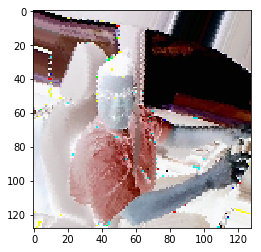

In [5]:
i = training_set.next()
plt.imshow(i[0][6])


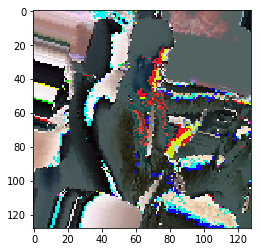

In [18]:
plt.imshow(vgg_preprocess(i[0][6]))

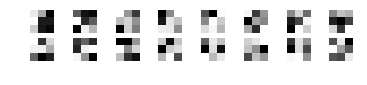

In [7]:
conv_layers = [l for l in model.layers if l.__class__ == Conv2D]
c = conv_layers[2]
CHANNEL=1
for FILTER in range(16):
    w = c.get_weights()[0]
    #print w.shape
    #print w[:,:,:,0].shape
    f = w[:,:,CHANNEL,FILTER]
    plt.subplot(8, 8, FILTER+1)
    plt.imshow(f, interpolation='nearest', cmap='Greys')
    plt.axis('off')

In [ ]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy', metrics=['categorical_accuracy'])
filepath="weights-improvement-{epoch:02d}-{categorical_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='categorical_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]



In [ ]:
model.fit_generator(training_set,
                         steps_per_epoch = training_set.samples /batch_size,
                         epochs = 100,
                         validation_data = val_set,
                         validation_steps = val_set.samples /batch_size,
                         callbacks=callbacks_list)


Epoch 1/5
523/523 [==============================] - 125s - loss: 2.3078 - categorical_accuracy: 0.1075 - val_loss: 2.3003 - val_categorical_accuracy: 0.1151
Epoch 2/5
523/523 [==============================] - 111s - loss: 2.3006 - categorical_accuracy: 0.1068 - val_loss: 2.3006 - val_categorical_accuracy: 0.1153
Epoch 3/5
523/523 [==============================] - 110s - loss: 2.3006 - categorical_accuracy: 0.1068 - val_loss: 2.3005 - val_categorical_accuracy: 0.1151
Epoch 4/5
522/523 [============================>.] - ETA: 0s - loss: 2.3003 - categorical_accuracy: 0.1079

In [ ]:
model.evaluate_generator(training_set, training_set.n/100)

In [ ]:
avg = np.zeros(3)
for i in range(1): #training_set.n/training_set.batch_size):
  data = training_set.next()
  d = data[0]
  #print d.shape
  #print avg, np.mean(data[0], axis=(0,1,2))
  avg = np.vstack([avg, np.mean(data[0], axis=(0,1,2))])
print avg


In [ ]:
np.mean(avg,axis=(0))

In [ ]:
submit_datagen = ImageDataGenerator() #'sub/test'
submit_set = submit_datagen.flow_from_directory('sub/test',
                                                target_size=(128,128),
                                                batch_size=64,
                                                class_mode=None,
                                                shuffle=False)

print submit_set.samples, submit_set.batch_size, submit_set.n
preds = model.predict_generator(submit_set, 
                                math.ceil(submit_set.n/64.0),
                                verbose=1
                               )
print len(preds)
assert len(preds) == len(submit_set.filenames)


In [ ]:
preds
with open('submission.csv', 'w') as csvfile:
  csvw = csv.writer(csvfile)
  csvw.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
  for fn, sc in zip(submit_set.filenames, preds):
    csvw.writerow([fn.split('/')[1]] + list(sc))

In [ ]:
preds.shape

In [ ]:
#submit_datagen = ImageDataGenerator() #'sub/test'
#submit_set = submit_datagen.flow_from_directory('sub/test2', target_size= (32,32),batch_size=1, 
#                                                class_mode=None, shuffle=False)

#print "beginning", submit_set.batch_size, submit_set.batch_index, submit_set.n
#preds = model.predict_generator(submit_set, submit_set.n ,verbose=0)
#print submit_set.batch_size, submit_set.batch_index


In [ ]:
#submit_set.index_generator.next()

In [ ]:
##submit_set.filenames

In [ ]:
#preds